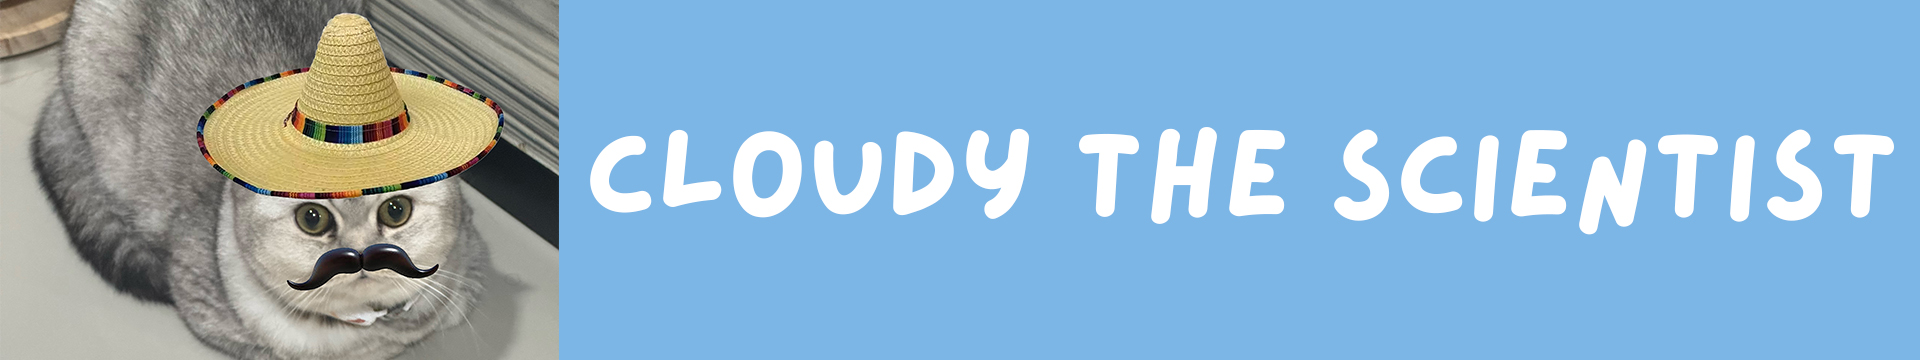

# ITCS227 Introduction to Data Science - Cloudy The Scientist (Group No.7)
# Garbage Classification (Recyclable or Non-Recyclable)

### Team Members:
- **6688077**: Bhumipat Pengpaiboon
- **6688108**: Napas Siripaskrittakul
- **6688142**: Krerkkiat Wattanaporn
- **6688178**: Fangyu Liu
- **6688228**: Nunnapat Vitinuntakit

<br>


---

The principles of zero-waste are straightforward actions to *minimize waste*, *conserve resources*, and *safeguard the environment*. By embracing these practices, we can make zero-waste living both simpler and more effective.

## Part 2 - Yolov8 Live Demo Powered By Supervision

##### Before you start, Let's make sure that we have all require library.

In [1]:
!pip install supervision==0.2.1
!pip install ultralytics

## The Yolov8 Live Demo
#### Material Classification Criteria

The following classification is used to recognized the recyclability of waste materials:

- **Recyclable Materials**:
  - *Cardboard*
  - *Glass*
  - *Plastic*
  - *Metal*
  - *Paper*

- **Non-Recyclable Material**:
  - *Biodegradable*

These categories are based on common recycling standards and are used to guide proper waste segregation.

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import supervision as sv

# Model paths
MODEL_PATHS = {
    "s": "runs/detect/train/weights/best.pt",
    "m": "runs/detect/train2/weights/best.pt",
    "x": "runs/detect/train4/weights/best.pt"
}

# The Class of materials
RECYCLABLE_CLASSES = ["CARDBOARD", "GLASS", "PLASTIC", "METAL", "PAPER"]
NON_RECYCLABLE_CLASSES = ["BIODEGRADABLE"]

def run_garbage_classifier(camera_index=0, model_type="s", webcam_resolution=(1920, 1080), conf=0.6):
    if model_type not in MODEL_PATHS:
        print("Invalid model type. Use 's', 'm', or 'x'.")
        return

    model_path = MODEL_PATHS[model_type]
    print(f"Calling YOLOv8{model_type.upper()} Garbage Classification training model")
    print(f"Using model: {model_path}")
    print(f"Confidence threshold: {conf}")

    cap = cv2.VideoCapture(camera_index)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, webcam_resolution[0])
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, webcam_resolution[1])

    model = YOLO(model_path)

    box_annotator = sv.BoxAnnotator(
        thickness=2,
        text_thickness=2,
        text_scale=1
    )

    # The size of region to classify size
    region_size = (400, 400)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Calculate the ratio of the center from camera
        h, w, _ = frame.shape
        center_x, center_y = w // 2, h // 2
        region_w, region_h = region_size
        x1 = max(center_x - region_w // 2, 0)
        y1 = max(center_y - region_h // 2, 0)
        x2 = min(center_x + region_w // 2, w)
        y2 = min(center_y + region_h // 2, h)
        roi = frame[y1:y2, x1:x2]

        # Object detection part
        result = model(roi, agnostic_nms=True)[0]
        detections = sv.Detections.from_yolov8(result)

        # Confidence part
        mask = detections.confidence > conf
        detections = detections[mask]

        labels = []
        for _, confidence, class_id, _ in detections:
            class_name = model.model.names[class_id]
            # The object is Recyclable
            if class_name in RECYCLABLE_CLASSES:
                recyclable_status = "Recyclable"
            elif class_name in NON_RECYCLABLE_CLASSES:
                recyclable_status = "Non-Recyclable"
            else:
                recyclable_status = "Unknown"
            labels.append(f"{class_name} {confidence:0.2f}")

        # The annotate of cropped space
        roi = box_annotator.annotate(scene=roi,detections=detections,labels=labels)
        frame[y1:y2, x1:x2] = roi
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        for i, (_, confidence, class_id, _) in enumerate(detections):
            class_name = model.model.names[class_id]
            # Check for Recyclable or Non-Recyclable
            if class_name in RECYCLABLE_CLASSES:
                recyclable_status = "Recyclable"
            elif class_name in NON_RECYCLABLE_CLASSES:
                recyclable_status = "Non-Recyclable"
            else:
                recyclable_status = "Unknown"
            cv2.putText(frame, recyclable_status, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        log_texts = [
            f"Model: YOLOv8{model_type.upper()}",
            f"Confidence: {conf:0.2f}"
        ]

        y_offset = 30
        for text in log_texts:
            cv2.putText(frame, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
            y_offset += 30

        cv2.imshow("Cloudy The Scientist: Garbage Classifier", frame)

        if cv2.waitKey(30) == 27:  # ESC to quit
            break

    cap.release()
    cv2.destroyAllWindows()

# Garbage Classification with YOLOv8 Models

This notebook allows you to run real-time garbage detection using a webcam and a trained YOLOv8 model.  
You can choose between **YOLOv8s**, **YOLOv8m**, or **YOLOv8x** versions of the model.

---

Run the cell that defines the `run_garbage_classifier()` function.  
It accepts the following parameters:

- `camera_index`: index of your webcam (e.g. `0`)
- `model_type`: choose one of the following:
  - `"s"` → YOLOv8 Small → `runs/detect/train/weights/best.pt`
  - `"m"` → YOLOv8 Medium → `runs/detect/train2/weights/best.pt`
  - `"x"` → YOLOv8 Extra-Large → `runs/detect/train4/weights/best.pt`
- `webcam_resolution`: default is `(1920, 1080)`
- `conf`: conf=0.6 will only show detections with a confidence of 60% or higher. default is 0.6

```python
run_garbage_classifier(camera_index=0, model_type="s")  # For YOLOv8s
run_garbage_classifier(camera_index=0, model_type="m")  # For YOLOv8m
run_garbage_classifier(camera_index=0, model_type="x")  # For YOLOv8x

- Pleae making sure that your webcam is connected and not used by another app.
- If camera_index=0 doesn’t work, try 1 or 2.
- To exit the application, press the ESC key.
- If the webcam fails to start, please try to restarting the kernel from the menu: 
  Kernel → Restart Kernel to release camera resources and try again.


In [ ]:
run_garbage_classifier(camera_index=0, model_type="m", conf=0.8)